# Bi-BFS Verification

In [52]:
# pre-settings
import networkx as nx
import matplotlib.pyplot as plt
import random
import queue

## Eg. Draw Directed-Graph using `networkx`

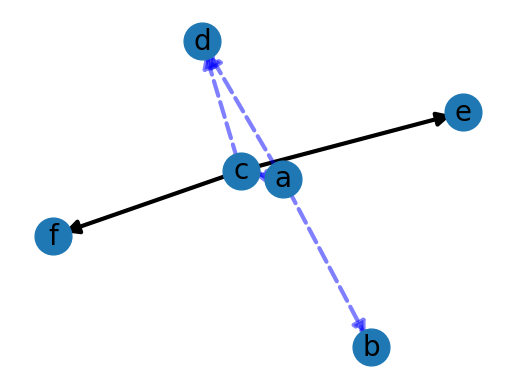

In [2]:
G1 = nx.DiGraph()

G1.add_edge('a', 'b', weight=0.6)
G1.add_edge('a', 'b', weight=0.2) # multiple adds for the same <src, dst> pair will be overlapped
# MultiGraph in networkx is multi-graph in mathematics
G1.add_edge('a', 'c', weight=0.2)
G1.add_edge('c', 'd', weight=0.1)
G1.add_edge('c', 'e', weight=0.7)
G1.add_edge('c', 'f', weight=0.9)
G1.add_edge('a', 'd', weight=0.3)

elarge = [(u, v) for (u, v, d) in G1.edges(data=True) if d['weight'] > 0.5]
esmall = [(u, v) for (u, v, d) in G1.edges(data=True) if d['weight'] <= 0.5]

pos = nx.spring_layout(G1)  # positions for all nodes

# nodes
nx.draw_networkx_nodes(G1, pos, node_size=700)

# edges
nx.draw_networkx_edges(G1, pos, edgelist=elarge,
                       width=3, arrowsize=20)
nx.draw_networkx_edges(G1, pos, edgelist=esmall,
                       width=3, alpha=0.5, edge_color='b', style='dashed', arrowsize=20)

# labels
nx.draw_networkx_labels(G1, pos, font_size=20, font_family='sans-serif')

plt.axis('off')
plt.show()

In [3]:
for path in nx.all_simple_paths(G1, source='a', target='d'):
    print(path)

['a', 'c', 'd']
['a', 'd']


In [24]:
list(G1.neighbors('e'))

[]

## Implement verification algorithm here
### Module1: Create graph
*Create testcases that may cover different kinds of conner cases*

In [31]:
case_id2_path = {0: "./testcase/dir-graph_001.dot",
                 1: "./testcase/dir-graph_002.dot"}

In [29]:
case_id2_src_dst = {0: ['a', 'b', 'c'],
                    1: ['a', 'f', 'e']}

In [26]:
def create_case(case_id, rand_src_dst = False):
    G = nx.drawing.nx_pydot.read_dot(case_id2_path[case_id])
    if rand_src_dst:
        G_node_list = list(G.nodes())
        random_items = random.sample(G_node_list, 3)
        return (G, random_items[:2], random_items[-1])
    else:
        return (G, case_id2_src_dst[case_id][:2], case_id2_src_dst[case_id][-1])

### Module2: Traverse the graph and create sub-graph using Bi-BFS

In [59]:
# do bfs multiple times to find reachable point to src and from dst
def bi_bfs(G, src_nodes, dst_node):
    srcs_reachable_set = set()
    for src in src_nodes:
        src_rechable_set = bfs(G, src)
        srcs_reachable_set = srcs_reachable_set.union(src_rechable_set)
    dst_reached_set = bfs(G, dst_node, True)
    sub_graph_nodes = dst_reached_set.intersection(srcs_reachable_set)
    sub_graph = G.subgraph(sub_graph_nodes)
    return sub_graph

In [63]:
# using bfs for reachable searching
def bfs(G, node, reverse_dir = False):
    waiting_queue = queue.Queue()
    waiting_queue.put(node)
    reachable_nodes = set({node, })
    while not waiting_queue.empty():
        present_node = waiting_queue.get()
        if reverse_dir:
            neighbour_list = G.predecessors(present_node)
        else:
            neighbour_list = G.neighbors(present_node)
        for n_v in neighbour_list:
            if n_v not in reachable_nodes:
                reachable_nodes.add(n_v)
                waiting_queue.put(n_v)
    return reachable_nodes

In [66]:
testcase1 = create_case(1)

display graph before slicing

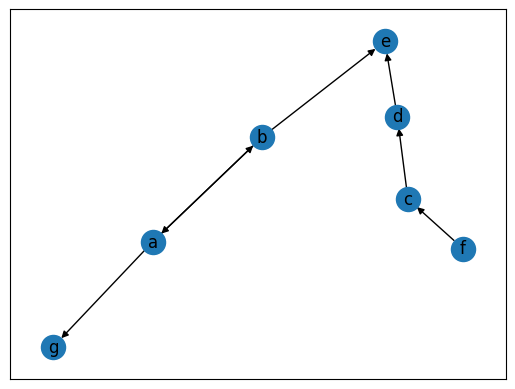

In [67]:
pos = nx.spring_layout(testcase1[0])  # positions for all nodes
nx.draw_networkx(testcase1[0], pos)

In [68]:
# do slicing, res is the sliced graph
res = bi_bfs(testcase1[0], testcase1[1], testcase1[2])

{'b', 'd', 'c', 'g', 'e', 'a', 'f'}


display graph after slicing

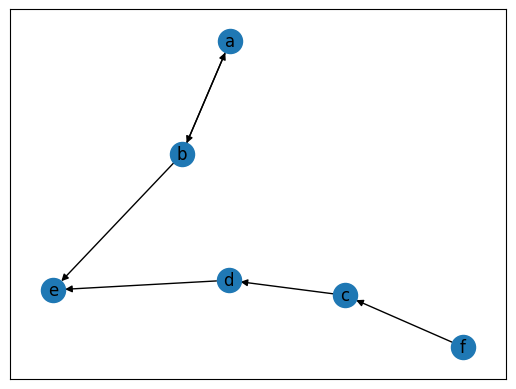

In [69]:
pos_sub = nx.spring_layout(res)
nx.draw_networkx(res,pos_sub)
plt.show()

### Module3: Output both graphs